# **run load_data.ipynb BEFORE running this!**

In [15]:
import pickle
import os.path
import numpy as np
PATH = 'model_dnn/'
LOG = "log_dnn"
data_file_name = 'data'

with open(data_file_name + '.pickle', 'rb') as handle:
    spectrum, temperature = pickle.load(handle)
    print(f"read data from {data_file_name}.pickle")
print(f"shape of spectrum data: {spectrum.shape}")
print(f"shape of temperature data: {temperature.shape}")
print()
print(f"there are {temperature.shape[0]} spectrums")
print(f"each spectrum is {spectrum.shape[1]} long, which is number of features")

read data from data.pickle
shape of spectrum data: (6000, 10000)
shape of temperature data: (6000, 1)

there are 6000 spectrums
each spectrum is 10000 long, which is number of features


In [16]:
indices_file_name = 'indices'
with open(indices_file_name + '.pickle', 'rb') as handle:
    train_indices, validate_indices, test_indices = pickle.load(handle)
    print(f"got indices from {indices_file_name}.pickle")  
print()
print(f"sets of training indices: {len(train_indices)}")
print(f"number of training indices per set: {len(train_indices[0])}")
print(f"sets of validating indices: {len(validate_indices)}")
print(f"number of validating indices per set: {len(validate_indices[0])}")
print(f"number of testing indices: {len(test_indices)}")
print()
input_dimension = spectrum.shape[1]
print(f"input dimension is:   {input_dimension}")
number_of_samples = spectrum.shape[0]
print(f"number of samples is: {number_of_samples}")
output_dimension = temperature.shape[1]
print(f"output dimension is:  {output_dimension}")

got indices from indices.pickle

sets of training indices: 16
number of training indices per set: 4200
sets of validating indices: 16
number of validating indices per set: 600
number of testing indices: 1200

input dimension is:   10000
number of samples is: 6000
output dimension is:  1


In [17]:
# how many parameters?
#   "a very simple two-layer ReLU network with p = 2n + d parameters 
#   that can express any labeling of any sample of size n in d dimensions
#   https://arxiv.org/pdf/1611.03530.pdf
#   https://stats.stackexchange.com/questions/320383/relationship-between-
#   model-over-fitting-and-number-of-parameters/320387#320387
import torch
import torch.nn as nn
class Model(torch.nn.Module):
    def __init__(self, device, input_dim=input_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 32
        self.output_dim = output_dimension
        self.sequential = torch.nn.Sequential(
            # torch.nn.Dropout(0.1),
            torch.nn.Linear(input_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.output_dim)
        )
        self.device = device
        self.to(device)
    def forward(self, x):
        y = self.sequential(x)
        # change: remove sigmoid, use y result as is
        # y = torch.sigmoid(y)
        return y
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# add scheduler
# https://arxiv.org/abs/1711.05101
# Adam can substantially benefit from a scheduled learning rate multiplier. 
# The fact that Adam is an adaptive gradient algorithm and as such adapts 
# the learning rate for each parameter does not rule out the possibility to 
# substantially improve its performance by using a global learning rate 
# multiplier, scheduled, e.g., by cosine annealing.
class Scheduler():
    def __init__(self, optimizer, patience, minimum_learning_rate, factor):
        # wait 'patience' number of epochs to change learning rate
        # learning rates' lower bound: 'minimum_learning_rate'
        # update learning rate by 'factor'ArithmeticError
        self.optimizer = optimizer
        self.patience = patience
        self.minimum_learning_rate = minimum_learning_rate
        self.factor = factor
        # use 'min' mode because:
        # we are monitoring loss
        # we do stuff when loss stops DEcreasing
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', patience=self.patience,
            factor=self.factor, min_lr=self.minimum_learning_rate,
        )
        # print(f"SCHEDULER: {self.scheduler}:")
        # print(f"\tpatience = {self.patience}, factor = {self.factor}" + 
        #       f"minimum_learning_rate = {minimum_learning_rate}")
    def __call__(self, validation_loss):
        self.scheduler.step(validation_loss)

In [19]:
# early stopping
# https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping
# -with-pytorch/
class EarlyStopping():
    def __init__(self, patience, min_delta):
        # if no improvement after 'patience' epochs, stop training
        # to count as improvement, need to change by 'min_delta' amount
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss > loss:
            # improved enough
            self.best_loss = loss
            self.counter = 0
        else:
            # did NOT improve enough :C
            self.counter += 1
        if self.counter >= self.patience:
            # it's stopping time! :C
            # no need reset early_stop, because we only use it once
            self.early_stop = True 

In [20]:
class SaveBestModel():
    def __init__(self, current_best_loss = float('inf')):
        self.current_best_loss = current_best_loss
    def __call__(self, current_loss, model, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            torch.save(model.state_dict(), PATH + f'round={round}' + '.pth')
# inherits from SaveBestModel
class SaveBestModel_filename(SaveBestModel):
    def __init__(self, current_best_loss = float('inf')):
        SaveBestModel.__init__(self, current_best_loss = float('inf'))
    def __call__(self, current_loss, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.current_best_model_filename = PATH + f'round={round}' + '.pth'

In [30]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
import numpy as np

# return: train_loss, validation_loss, current model
class trainer():
    def __init__(self, net, n_epochs, batch_size, learning_rate,
                 cross_validation_round, loss_function):
        super().__init__()
        self.net = net
        self.net.apply(self.initializer)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.cross_validation_round = cross_validation_round
        self.optimizer = optim.AdamW(self.net.parameters(), 
                        lr=learning_rate, weight_decay=3e-3) 
        self.scheduler = Scheduler(optimizer=self.optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        # self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        #     optimizer = self.optimizer,
        #     T_0=15,
        #     T_mult=2
        # )
        # self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 
        #                                                        T_max=800, 
        #                                                        eta_min=0, 
        #                                                        last_epoch=-1, 
        #                                                        verbose=False)

        self.stopper = EarlyStopping(patience=5, min_delta=1e-7)
        self.criterion = loss_function
    # use He initialization (because of RELU units in model definition)  
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def get_loss(self, train_data, train_label, test_data, test_label):
        # datasets
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data).to(device), 
            torch.Tensor(train_label).to(device))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data).to(device), 
            torch.Tensor(test_label).to(device))
        # dataloaders
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, 
                                  **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, 
                                **loader_args)
        iters = len(val_loader)
        """SETUP"""
        train_loss = []
        validate_loss = []

        # scheduler action affects the optimizer!
        saver = SaveBestModel()

        for epoch in range(0, self.n_epochs):
            # training
            epoch_train_loss=[]
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.net.device))
                loss = self.criterion(y_pred, label.to(self.net.device))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_train_loss.append(loss.item())
                # cosine annealing warm restart?
                # self.scheduler.step(epoch + i / iters)
            train_loss.append(np.mean(epoch_train_loss))

            # validation
            epoch_validate_loss=[]
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs_validate, label_validate = data
                    y_pred_validate = self.net(
                        inputs_validate.to(self.net.device))
                    loss_validate = self.criterion(
                        y_pred_validate, 
                        label_validate.to(self.net.device)) # one number
                    epoch_validate_loss.append(loss_validate.item())
            validate_loss.append(np.mean(epoch_validate_loss))
            # save best model
            saver(current_loss=np.mean(epoch_validate_loss), 
                  model=self.net, 
                  round=self.cross_validation_round
                  )
            # scheduler & early stopping
            self.scheduler(np.mean(epoch_validate_loss))
            # self.scheduler.step()
            self.stopper(np.mean(epoch_validate_loss))
            if self.stopper.early_stop == True:
                # print(f"\tEARLY STOPPING @ epoch {epoch}")
                # print(f"\tstopping counter: {self.stopper.counter}")
                # print(f"\tstopping loss: {self.stopper.best_loss}")
                break
        # plot result w.r.t epoch
        # plt.subplot()
        # plt.plot(train_loss)
        # plt.plot(validate_loss)
        # plt.show()
        min_validate_loss = np.min(validate_loss)
        min_index = validate_loss.index(min_validate_loss)
        min_train_loss = np.min(train_loss)
        return min_train_loss, min_validate_loss, self.net

In [22]:
# clean up memory just in case!
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.memory_summary()

it's training time
necessary params count: 22000
actual params count: 321121
	total trainable parameters: 321121
number of epochs: 2000, batch size: 64, device: cuda, learning rate 5e-05
NOTE: training loss is blue, validation loss is orange

training starts:
cross-validation round no.0
	minimum training loss:        0.04153922498226166
	minimum validation loss:      0.06027044066124492
	validate/train = 1.4509283860491375
	time: 2023-05-31 11:13:32
cross-validation round no.1
	minimum training loss:        0.10544932817037289
	minimum validation loss:      0.19687793486648136
	validate/train = 1.8670383043919316
	time: 2023-05-31 11:13:37
cross-validation round no.2
	minimum training loss:        0.034569854747790556
	minimum validation loss:      0.06238222701681985
	validate/train = 1.8045267320889409
	time: 2023-05-31 11:13:52
cross-validation round no.3
	minimum training loss:        0.03565627027016419
	minimum validation loss:      0.06791367299026912
	validate/train = 1.9046768

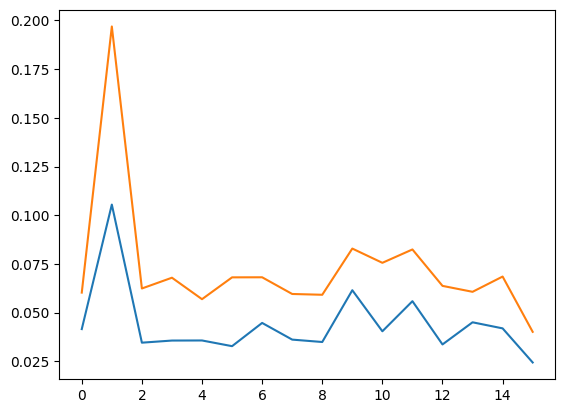

the best model is: model_dnn/round=15.pth
ratios: [1.4509283860491375, 1.8670383043919316, 1.8045267320889409, 1.9046768626021071, 1.5936879459797761, 2.077578804287602, 1.5241707659106922, 1.648100813871228, 1.6944184319872715, 1.347708218237754, 1.8694595856929015, 1.4753078680571652, 1.8929548068436937, 1.3475545845730976, 1.6347343586172056, 1.644615375751449]


In [31]:
# Theory suggests that when multiplying the batch size by k, 
# one should multiply the learning rate by sqrt(k) to keep the variance 
# in the gradient expectation constant. See page 5 at A. Krizhevsky. 
# One weird trick for parallelizing convolutional neural networks: 
# https://arxiv.org/abs/1404.5997
# 
# However, recent experiments with large mini-batches suggest for a simpler 
# linear scaling rule, i.e multiply your learning rate by k when using 
# mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: 
# Training ImageNet in 1 Hour 
# https://arxiv.org/abs/1706.02677
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import copy
print("it's training time")

n_epochs = 2000
batch_size = 64
learning_rate = 5e-5

"""model setup"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl = Model(device=device, input_dim=input_dimension)
print(f"necessary params count: {2 * number_of_samples + input_dimension}")
total_params = sum(p.numel() for p in mdl.parameters())
print(f"actual params count: {total_params}")
total_params_trainable = sum(p.numel() for p in mdl.parameters() 
                             if p.requires_grad)
print(f"\ttotal trainable parameters: {total_params_trainable}")

loss_function = nn.MSELoss()
train_losses = []
validate_losses = []
print(f"number of epochs: {n_epochs}, batch size: {batch_size}, " + 
      f"device: {mdl.device}, learning rate {learning_rate}")
print("NOTE: training loss is blue, validation loss is orange")
print()
print("training starts:")

ratios = []
Path(PATH).mkdir(parents=True, exist_ok=True)
saver = SaveBestModel_filename()
for cross_validation_round, (train, validate) in enumerate(zip(train_indices, validate_indices)):
    print(f"cross-validation round no.{cross_validation_round}")
    # use indices to extract training & testing set for current 
    # cross-validation round
    train_data, train_label = spectrum[train], temperature[train]
    validate_data, validate_label = spectrum[validate], temperature[validate]
    # normalize training data, scaler normalize direction = column
    scaler = StandardScaler()
    scaler.fit(train_data)
    train_data_n = scaler.transform(np.copy(train_data))
    # 'normalize' testing data, using transformation for training data 
    # (prevents data snooping)
    validate_data_n = scaler.transform(np.copy(validate_data))
    trainer_object = trainer(mdl, n_epochs, batch_size=batch_size, 
                              learning_rate=learning_rate,
                              cross_validation_round=cross_validation_round,
                              loss_function=loss_function)
    train_loss, validate_loss, model = trainer_object.get_loss(
                                        train_data_n, 
                                        train_label, 
                                        validate_data_n, 
                                        validate_label)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    saver(current_loss=validate_loss, round=cross_validation_round)
    print(f"\tminimum training loss:        {train_loss}")
    print(f"\tminimum validation loss:      {validate_loss}")
    print(f"\tvalidate/train = {validate_loss/train_loss}")
    ratios.append(validate_loss/train_loss)
    print("\ttime: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print()
print("training and validation loss, across cross-validation rounds")
plt.subplot()
plt.plot(train_losses)
plt.plot(validate_losses)
plt.show()

best_model_filename = saver.current_best_model_filename
print(f"the best model is: {best_model_filename}")
print(f"ratios: {ratios}")

In [32]:
losses_mean = np.mean(validate_losses)
losses_std = np.std(validate_losses)
losses_min = np.min(validate_losses)
print(f"min validation losses: {losses_min} <- model selected")
print(f"mean validation losses: {losses_mean}") 
print(f"std: {losses_std}")
print()

print("loading best model")
best_model = Model(device=device, input_dim=input_dimension)
print(best_model.load_state_dict(torch.load(best_model_filename)))
print()

print("it's inference time!")
test = test_indices
test_data, test_label = spectrum[test], temperature[test]
scaler = StandardScaler()
scaler.fit(train_data)
test_data_n = scaler.transform(np.copy(test_data))
test_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data_n).to(device), 
            torch.Tensor(test_label).to(device))
loader_args = dict(batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, drop_last=True, 
                            **loader_args)
test_losses = []
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs_test, label_test = data
        y_pred_test = best_model(inputs_test.to(device))
        loss_test = loss_function(y_pred_test, 
                        label_test.to(device))
        test_losses.append(loss_test.item())
print(f"mean test loss: {np.mean(test_losses)}")
print(f"test/validate = {np.mean(test_losses)/losses_min}")

min validation losses: 0.04013359339700805 <- model selected
mean validation losses: 0.07332444467788769
std: 0.03340560682363199

loading best model
<All keys matched successfully>

it's inference time!
mean test loss: 0.04641250024239222
test/validate = 1.1564501534480653


In [ ]:
number_figures = 10
import matplotlib.pyplot as plt

scaler = StandardScaler()
spectrum_normalized = np.copy(spectrum)
spec_normalized = scaler.fit_transform(spectrum)

indices = torch.randint(0, len(spectrum),(number_figures,)).unique()
for i in indices:
    print(f"we use {i}th example")
    # change: cast i to int, since pandas not work with torch.int64
    # changed: removed figure, since the output is just one number
    spec = np.asarray(spec_normalized[int(i)]).flatten()
    temp = np.asarray(temperature[int(i)]).flatten()
    
    # print(np.asarray(spectrum[int(i)]).flatten())
    # print(spec)
    prediction = best_model(torch.Tensor(spec).to(model.device)).detach().cpu().flatten()
    
    prediction = prediction.item()
    ground_truth = temp.item()
    # recover data from normalization
    print(f"-----------------------------------------------------")
    print(f"\tthe prediction is: {prediction}")
    print(f"\tthe ground truth is: {ground_truth}")
    print(f"\tthe difference is: {prediction - ground_truth}")


we use 895th example
-----------------------------------------------------
	the prediction is: 20.476768493652344
	the ground truth is: 20.7
	the difference is: -0.22323150634765554
we use 1404th example
-----------------------------------------------------
	the prediction is: 20.699501037597656
	the ground truth is: 20.7
	the difference is: -0.0004989624023430395
we use 2092th example
-----------------------------------------------------
	the prediction is: 22.395238876342773
	the ground truth is: 21.5
	the difference is: 0.8952388763427734
we use 3353th example
-----------------------------------------------------
	the prediction is: 20.53883934020996
	the ground truth is: 20.7
	the difference is: -0.16116065979003835
we use 3603th example
-----------------------------------------------------
	the prediction is: 22.421489715576172
	the ground truth is: 21.7
	the difference is: 0.7214897155761726
we use 3703th example
-----------------------------------------------------
	the predicti

# **skip cell 14 for now (it's in template file!)**